In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
from sqlalchemy import inspect
inspector = inspect(engine)

# list attributes for each table
for i in inspector.get_columns('measurement'): print(i["name"], i["type"])
print("-"*12)
for i in inspector.get_columns('station'): print(i["name"], i["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# query most recent entry
last_entry = engine.execute("SELECT * FROM measurement ORDER BY date DESC").first()

# compute date 12 months ago
last_12_months = dt.datetime.strptime(last_entry.date, '%Y-%m-%d') - dt.timedelta(days=365)


In [47]:
# convert details of last 12 months into dataframe
stmt = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_12_months).statement
prcp_df = pd.read_sql(stmt, session.bind)
prcp_df = prcp_df.sort_values("date").set_index("date")

prcp_df = prcp_df.rename(columns={"prcp" : "precipitation"}).dropna()

prcp_df


,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.06


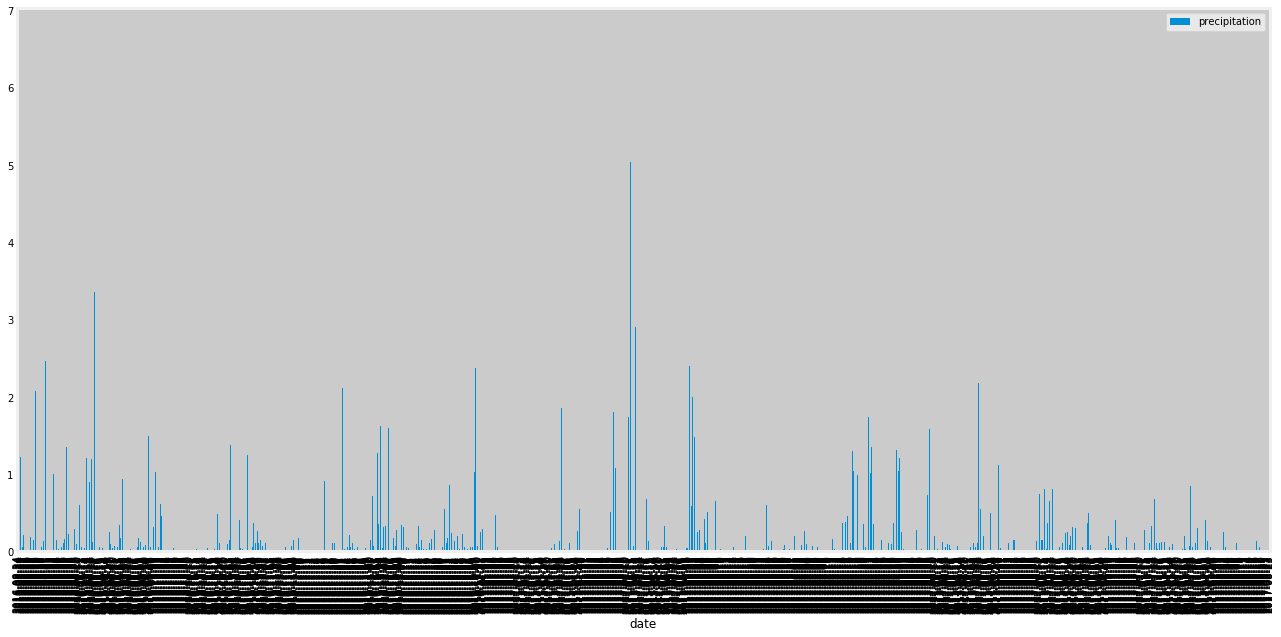

In [58]:
prcp_df.plot(kind='bar', figsize=(20,10))
plt.show()


In [54]:
test_df = prcp_df.groupby("date").sum()

# test_df.plot(kind='bar', figsize=(20,10))
# plt.show()


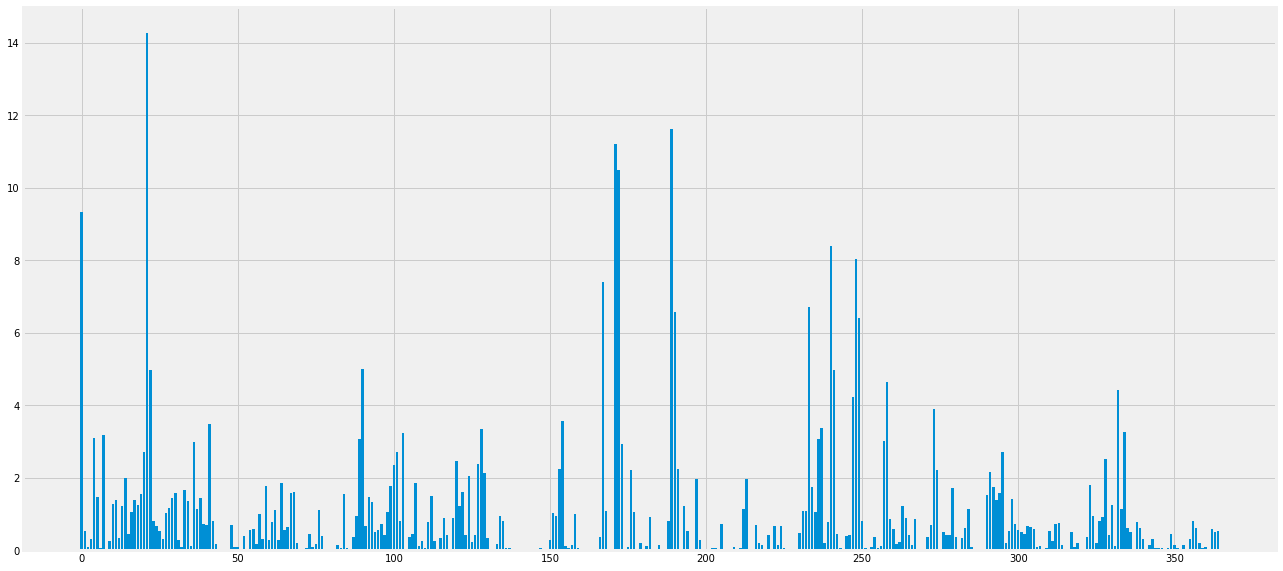

In [55]:
# bar plot precipitation values
fig, ax = plt.subplots(figsize=(20,10))

row, col = test_df.shape

x_axis = np.arange(0, row, step=1)
ax.bar(x_axis, test_df.precipitation)

plt.show()


![precipitation](Resources/Images/precipitation.png)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Resources/Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct(Measurement.station).count()


9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = station_activity[0][0]

temp_summary = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active).first()

summary = f'''
The most active station is {most_active} with
lowest temperature recorded: {temp_summary[0]:.2f}
highest temperature recorded: {temp_summary[1]:.2f}
average temperature: {temp_summary[2]:.2f}
'''

print(summary)



The most active station is USC00519281 with
lowest temperature recorded: 54.00
highest temperature recorded: 85.00
average temperature: 71.66



In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

obs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station) \
    .filter(Measurement.tobs.isnot(None)).order_by(func.count(Measurement.tobs).desc()).all()

tobs_data = session.query(Measurement.tobs).filter(Measurement.date >= last_12_months)\
    .filter(Measurement.station == obs[0][0]).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

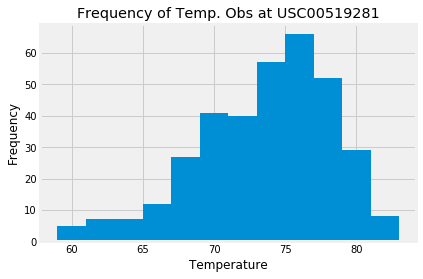

In [21]:
fig, ax = plt.subplots()

pd.DataFrame(tobs_data).hist(bins=12, ax=ax)

ax.set_title(f"Frequency of Temp. Obs at {obs[0][0]}")
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")

plt.show()


In [22]:
# station_activity
measurement_df.loc[measurement_df["tobs"] == 0 , :]

measurement_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2223 entries, 2016-08-24 to 2017-08-23
Data columns (total 4 columns):
id         2223 non-null int64
station    2223 non-null object
prcp       2015 non-null float64
tobs       2223 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 166.8+ KB


In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.datetime.strptime("2012-01-01", '%Y-%m-%d')
trip_length = np.random.randint(low=3, high=15)
end_date =  start_date + dt.timedelta(days=trip_length)

trip_temps = calc_temps(start_date, end_date)[0]

trip_temps


(61.0, 68.36986301369863, 76.0)

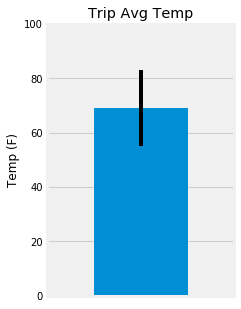

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=(3,5))

yerr = trip_temps[2] - trip_temps[0]

ax.bar(1, height=trip_temps[1], width=0.5, yerr=yerr)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp (F)")

ax.set_xlim([0.5, 1.5])
ax.set_ylim([0, 100])
ax.xaxis.set_visible(False)

plt.show()


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, 
       Station.elevation, func.sum(Measurement.prcp)]

session.query(*sel).filter(Measurement.station==Station.station).filter()\
    .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
    .group_by(Station.id).order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.30000000000000004),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.2),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.05),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.0)]

## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


# create list of all days on trip in %m-%d
trip_dates = [start_date + dt.timedelta(days=i) for i in range(trip_length+1)]
trip_days = [date.strftime("%m-%d") for date in trip_dates]

# calculate daily normals for all days
normals = []
for day in trip_days:
    normals.append(daily_normals(day)[0])

normals


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# convert trip dates from datetime to string
trip_dates = [date.strftime("%Y-%m-%d") for date in trip_dates]

# load results into DataFrame
daily_norm_df = pd.DataFrame(data=normals, index=trip_dates, columns = ['tmin', 'tavg', 'tmax'])
daily_norm_df.index.name = 'date'

daily_norm_df


,tmin,tavg,tmax
date,,,
2012-01-01,62.0,69.153846,77.0
2012-01-02,60.0,69.396226,77.0
2012-01-03,62.0,68.909091,77.0
2012-01-04,58.0,70.000000,76.0
2012-01-05,56.0,67.964286,76.0
2012-01-06,61.0,68.964912,76.0
2012-01-07,57.0,68.543860,76.0
2012-01-08,57.0,67.160714,75.0
2012-01-09,58.0,67.929825,78.0


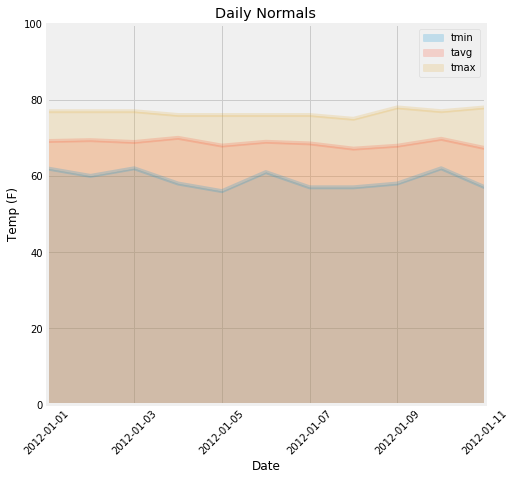

In [43]:
# Plot the daily normals as an area plot with `stacked=False`

fig, ax = plt.subplots(figsize=(7, 7))

daily_norm_df.plot.area(stacked=False, alpha=0.20, rot=45, ax=ax)
ax.set(title='Daily Normals', xlabel='Date', ylabel='Temp (F)')

ax.set_ylim([0,100])

plt.grid(True)
plt.show()


# Temperature Analysis

We look to determine if there is any meaningful temperature difference between the months of June and December.

In [18]:
# convert measurement and station data into dataframes
measurement_qry = session.query(Measurement).statement
station_qry = session.query(Station).statement

measurement_df = pd.read_sql(measurement_qry, session.bind)
station_df = pd.read_sql(measurement_qry, session.bind)


In [19]:
# convert dates into type datetime 
measurement_df["date"] = pd.to_datetime(measurement_df["date"], format="%Y-%m-%d")
station_df["date"] = pd.to_datetime(station_df["date"], format="%Y-%m-%d")


In [20]:
# grab data for June and December 
june_df = measurement_df[measurement_df.date.dt.month == 6]
dec_df = measurement_df[measurement_df.date.dt.month == 12]


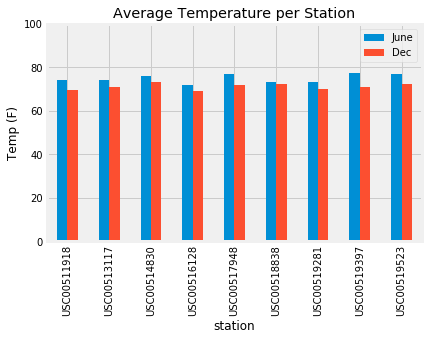

In [57]:
# compute average temperature per station
june_station_avg= june_df.groupby("station").mean()["tobs"]
dec_station_avg = dec_df.groupby("station").mean()["tobs"]

joined_avg_df = pd.concat([june_station_avg, dec_station_avg], axis=1, keys=("June", "Dec"))

ax = joined_avg_df.plot(kind='bar')
ax.set(title="Average Temperature per Station", ylabel="Temp (F)")
ax.set_ylim([0,100])

plt.show()


Since we take observations from the same stations, but at different times, we perform a paired t-test to determine if the difference of means is significant.


In [22]:
from scipy import stats

statistic, pvalue = stats.ttest_rel(june_station_avg, dec_station_avg)

pvalue


0.00011759380231523222